In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import TensorBoard
import datetime

In [2]:
# Erstelle ein Verzeichnis für die TensorBoard-Logs
log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [3]:
# Pfad zur CSV-Datei angeben
csv_file = './Chest_xray_Corona_Metadata.csv'
# CSV-Datei laden
data = pd.read_csv(csv_file)
data = data.sample(frac=1, random_state=1).reset_index(drop=True)
# Zuerst den gesamten Datensatz in Trainings- und Testset aufteilen (80% Training, 20% Test)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Dann das Trainingsset in ein tatsächliches Trainingsset und ein Validierungsset aufteilen (80% Train, 20% Validierung)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

print(f"Training samples: {len(train_data)}, Validation samples: {len(val_data)}, Test samples: {len(test_data)}")


Training samples: 3782, Validation samples: 946, Test samples: 1182


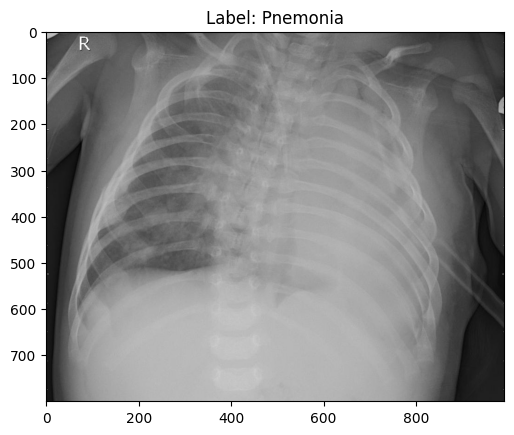

In [4]:
import matplotlib.pyplot as plt
import cv2
import os

# Beispielbild laden und anzeigen
image_folder = './Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/'  # Ordner, in dem sich die Bilder befinden

# Nimm das erste Bild aus der CSV-Datei
image_name = data['X_ray_image_name'].iloc[0]
image_path = os.path.join(image_folder, image_name)

# Bild laden und anzeigen
image = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f"Label: {data['Label'].iloc[20]}")
plt.show()


In [5]:
# Überprüfe die Verteilung der Klassen
class_distribution = data['Label'].value_counts()
print(class_distribution)
# Gesamtzahl der Bilder
total = len(data)

# Häufigkeit jeder Klasse
class_counts = class_distribution.to_dict()

# Klassengewichte berechnen (Inverse der Häufigkeit)
class_weights = {label: total/count for label, count in class_counts.items()}
# Verwende die Klassenindizes aus dem Generator
class_weights = {
    0: class_weights['Normal'],    # Index 0 für 'Normal'
    1: class_weights['Pnemonia']   # Index 1 für 'Pnemonia'
}
print(class_weights)


Label
Pnemonia    4334
Normal      1576
Name: count, dtype: int64
{0: 3.75, 1: 1.3636363636363635}


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Definiere die Bildgröße und Batch-Größe
image_size = (224, 224)
batch_size = 8

# Datenaugmentation und Normalisierung
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    fill_mode='nearest'
    )

# Training-Daten laden
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,  # Verwende den train_data DataFrame
    directory=image_folder,
    x_col='X_ray_image_name',
    y_col='Label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True,  # Mische die Trainingsdaten
    workers=6
)

# Generator für Validierungs- und Testdaten (keine Augmentation, nur Rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Validierungsdaten-Generator
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory=image_folder,
    x_col='X_ray_image_name',
    y_col='Label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False  # Keine Notwendigkeit, Validierungsdaten zu mischen
)

# Testdaten-Generator
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=image_folder,
    x_col='X_ray_image_name',
    y_col='Label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False  # Testdaten ebenfalls nicht mischen
)

Found 3782 validated image filenames belonging to 2 classes.
Found 946 validated image filenames belonging to 2 classes.
Found 1182 validated image filenames belonging to 2 classes.


In [7]:
from tensorflow.keras import layers, models, regularizers

# Input-Größe anpassen (224x224 Bilder, Graustufen -> 1 Kanal)
input_shape = (224, 224, 1)

# CNN-Modell für 224x224 Röntgenbilder aufbauen
model = models.Sequential([
    # Erste Convolution-Schicht mit 32 Filtern
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape,
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),  # Batch-Normalisierung hinzufügen
    layers.MaxPooling2D((2, 2)),

    # Zweite Convolution-Schicht mit 64 Filtern
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),  # Batch-Normalisierung hinzufügen
    layers.MaxPooling2D((2, 2)),

    # Dritte Convolution-Schicht mit 128 Filtern
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),  # Batch-Normalisierung hinzufügen
    layers.MaxPooling2D((2, 2)),

    # Vierte Convolution-Schicht mit 256 Filtern für mehr Tiefenlernen
    layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),  # Batch-Normalisierung hinzufügen
    layers.MaxPooling2D((2, 2)),

    # Global Average Pooling statt Flatten, um Parameterzahl zu reduzieren
    layers.GlobalAveragePooling2D(),

    # Dichte Schicht mit 128 Neuronen
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),  # Dropout zur Vermeidung von Overfitting

    # Output-Layer für Multiklassen-Klassifikation (Softmax)
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

# Modell-Übersicht anzeigen
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 64)     256       
 hNormalization)                                                 
                                                        

In [8]:
# Modell kompilieren
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',  # Verwende binary_crossentropy für binäre Klassifikation
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.001)
# Modell trainieren
tf.debugging.set_log_device_placement(True)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, tensorboard_callback]
    )


Epoch 1/50
473/473 [==============================] - 50s 101ms/step - loss: 1.3505 - accuracy: 0.7927 - val_loss: 1.7105 - val_accuracy: 0.7442
Epoch 2/50
473/473 [==============================] - 48s 101ms/step - loss: 1.2111 - accuracy: 0.8310 - val_loss: 0.9067 - val_accuracy: 0.7558
Epoch 3/50
473/473 [==============================] - 48s 100ms/step - loss: 1.1548 - accuracy: 0.8318 - val_loss: 0.7802 - val_accuracy: 0.8594
Epoch 4/50
473/473 [==============================] - 46s 98ms/step - loss: 1.1392 - accuracy: 0.8416 - val_loss: 0.7500 - val_accuracy: 0.8636
Epoch 5/50
473/473 [==============================] - 46s 98ms/step - loss: 1.1139 - accuracy: 0.8503 - val_loss: 0.8364 - val_accuracy: 0.8171
Epoch 6/50
473/473 [==============================] - 46s 98ms/step - loss: 1.0590 - accuracy: 0.8556 - val_loss: 0.8019 - val_accuracy: 0.8266
Epoch 7/50
473/473 [==============================] - 47s 99ms/step - loss: 1.0377 - accuracy: 0.8575 - val_loss: 0.6321 - val_accura

In [9]:
model.save('./models/cnn.keras')

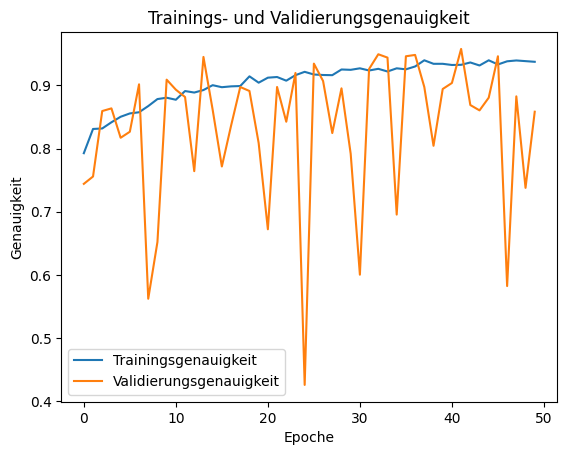

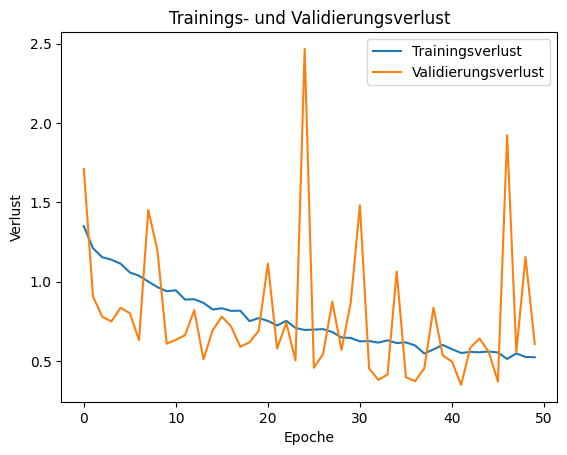

In [10]:
# Trainings- und Validierungsgenauigkeit
plt.plot(history.history['accuracy'], label='Trainingsgenauigkeit')
plt.plot(history.history['val_accuracy'], label='Validierungsgenauigkeit')
plt.title('Trainings- und Validierungsgenauigkeit')
plt.xlabel('Epoche')
plt.ylabel('Genauigkeit')
plt.legend()
plt.show()

# Trainings- und Validierungsverlust
plt.plot(history.history['loss'], label='Trainingsverlust')
plt.plot(history.history['val_loss'], label='Validierungsverlust')
plt.title('Trainings- und Validierungsverlust')
plt.xlabel('Epoche')
plt.ylabel('Verlust')
plt.legend()
plt.show()

In [12]:
import keras
model = keras.models.load_model('./models/cnn.keras')

In [13]:
# Modell auf den Testdaten evaluieren
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Testverlust: {test_loss}, Testgenauigkeit: {test_accuracy}')


148/148 [==============================] - 9s 58ms/step - loss: 0.5515 - accuracy: 0.8613
Testverlust: 0.5515486001968384, Testgenauigkeit: 0.8612521290779114


148/148 [==============================] - 9s 61ms/step


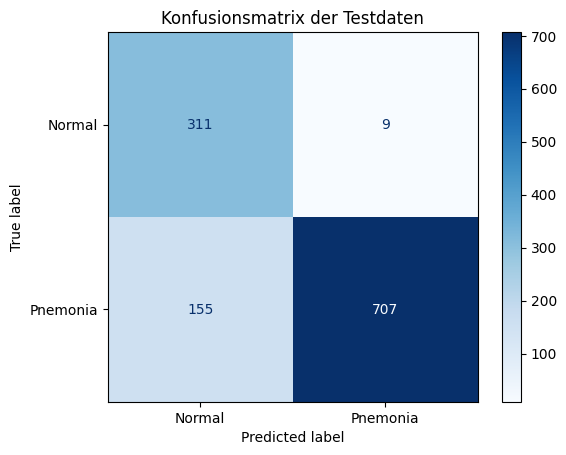

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Schritt 1: Vorhersagen für das Testset erstellen
# hole wahrscheinlichkeit pro klasse
predictions = model.predict(test_generator)
# ermittel die klasse mit höchster wahrscheinlichkeit
y_pred = np.argmax(predictions, axis=1)

# Schritt 2: Tatsächliche Klassenlabels aus dem Testset extrahieren
y_true = test_generator.classes  # Das sind die tatsächlichen Klassenlabels

# Schritt 3: Konfusionsmatrix erstellen
conf_matrix = confusion_matrix(y_true, y_pred)

# Schritt 4: Konfusionsmatrix visualisieren
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Konfusionsmatrix der Testdaten')
plt.show()


In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

test_dir = "./Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/"
save_dir = './cnn_false_negatives/'
# Vorhersagen auf den Testdaten erhalten
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Klassenindizes und Labels erhalten
class_indices = test_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}
filenames = test_generator.filenames
true_class_indices = test_generator.classes
predicted_class_indices = np.argmax(predictions, axis=1)

# Indizes für die Klassen 'Pneumonia' und 'Normal' erhalten
positive_class_name = 'Pnemonia'
negative_class_name = 'Normal'

positive_class_index = class_indices[positive_class_name]
negative_class_index = class_indices[negative_class_name]

# Durchlaufen der Vorhersagen und Speichern der falsch-negativen Fälle
for i in range(len(filenames)):
    true_label = true_class_indices[i]
    predicted_label = predicted_class_indices[i]
    if true_label == positive_class_index and predicted_label == negative_class_index:
        # Falsch-negative Vorhersage
        image_path = os.path.join(test_dir, filenames[i])
        # Bild laden
        img = Image.open(image_path)
        # Vorhergesagte Wahrscheinlichkeiten
        probs = predictions[i]
        # Erstellen der kombinierten Darstellung
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        # Röntgenbild anzeigen
        ax1.imshow(img, cmap='gray')
        ax1.axis('off')
        ax1.set_title('Röntgenbild')
        # Säulendiagramm der Vorhersagen
        ax2.bar(class_labels.values(), probs)
        ax2.set_ylim([0, 1])
        ax2.set_title('Vorhergesagte Wahrscheinlichkeiten')
        ax2.set_ylabel('Wahrscheinlichkeit')
        # Bild speichern
        save_path = os.path.join(save_dir, f"FalseNegative_{i}.png")
        plt.savefig(save_path)
        plt.close(fig)

148/148 [==============================] - 9s 59ms/step
